# City Bike Route Analysis & Visualization：

任务描述： 本脚本用于分析 2023 年 City Bike 数据，以找出用户最常使用的骑行路线， 并使用 Google Maps API 在地图上高亮显示这些路线。 

功能概要：

 1. **数据加载与清洗**： - 加载来自 CSV 文件的骑行数据。 - 处理缺失值，过滤不合理的数据（如骑行时间异常）。 

2. **路线频率统计**： - 根据骑行的起点和终点，创建唯一的路线标识符。 - 统计不同路线的使用频次，找出最常骑行的路线。

 3. **路线可视化**： - 使用 Google Maps API 获取最常骑行路线的详细路径。 - 使用 Folium 库生成交互式地图，并高亮显示这些最常骑行的路线。 - 将生成的地图保存为 HTML 文件，供浏览器查看。 

注意事项： 
- 确保已安装依赖库：`pandas`、`folium`、`googlemaps`、`python-dotenv`。 - 使用 `.env` 文件存储 Google Maps API 密钥，确保密钥安全。 

- 请在运行前修改 `data_file` 变量的路径，以匹配实际存储的数据文件路径。 

1. **数据加载与清洗**

CitiBike 行程数据集，使用了 2023 年的数据，由于计算限制，我创建了 1/1000 的样本。这些样本是非确定性创建的，通过从文件中随机选择“r nrow(file)/1000”来创建。

In [16]:
# 文件路径: C:\Users\lsy\Desktop\CityBikeAnalysis2\data\citibike_sampled_cleaned_2023.csv

# 导入所需的库
import pandas as pd
import os

# 加载数据文件
data_file = r'C:\Users\lsy\Desktop\CityBikeAnalysis2\data\citibike_sampled_cleaned_2023.csv'

# 第一步：使用 pandas 加载数据集
# 将 CSV 文件加载到一个 DataFrame 中
try:
    df = pd.read_csv(data_file)
    print(f"数据加载成功。记录数: {len(df)}")
except FileNotFoundError:
    print("指定的数据文件未找到。请检查文件路径。")
    exit()

# 第二步：清洗数据
# 删除关键列中包含缺失值的行
# 关键列包括 'start_station_name'、'end_station_name' 和 'ride_duration'
critical_columns = ['start_station_name', 'end_station_name', 'ride_duration']
df.dropna(subset=critical_columns, inplace=True)
print(f"删除缺失值后的数据。记录数: {len(df)}")

# 将 ride_duration 转换为数值型（如果尚未是数值型）
# 假设 'ride_duration' 是以分钟为单位
df['ride_duration'] = pd.to_numeric(df['ride_duration'], errors='coerce')

# 删除无效的 ride_duration（例如，负值或 NaN）
df = df[(df['ride_duration'] > 0) & (~df['ride_duration'].isna())]
print(f"删除无效骑行时长后的数据。记录数: {len(df)}")

# 进一步过滤异常的骑行时长，例如，删除超过合理阈值的骑行（如超过 24 小时）
reasonable_trip_duration_limit = 1440  # 24 小时（以分钟为单位）
df = df[df['ride_duration'] <= reasonable_trip_duration_limit]
print(f"过滤掉超过 24 小时骑行后的数据。记录数: {len(df)}")

# 第三步：查看清洗后的数据
print(df.head())

# 接下来的步骤：保存清洗后的数据，或继续进行路线频率分析。


C:\Users\lsy\AppData\Local\Temp\ipykernel_55104\1319183195.py:13: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


数据加载成功。记录数: 349090
删除缺失值后的数据。记录数: 349090
删除无效骑行时长后的数据。记录数: 349090
过滤掉超过 24 小时骑行后的数据。记录数: 349090
            ride_id  rideable_type               started_at  \
0  654C13B23F75720F  electric_bike  2023-08-01 19:11:13.917   
1  4A6AD84D1678C2BF   classic_bike  2023-12-04 16:02:48.656   
2  6F23B7CFD153B060  electric_bike  2023-01-22 13:47:42.586   
3  B046F67BF8D00FD4  electric_bike  2023-07-26 21:02:40.248   
4  40316B4BBE42DB94   classic_bike  2023-06-20 13:12:05.431   

                  ended_at           start_station_name start_station_id  \
0  2023-08-01 19:38:37.345       Hanson Pl & Ashland Pl          4395.07   
1  2023-12-04 16:30:13.045        West St & Chambers St          5329.03   
2  2023-01-22 13:54:17.697         Roebling St & N 4 St          5267.09   
3  2023-07-26 21:23:49.546           S 4 St & Wythe Ave          5204.05   
4  2023-06-20 13:43:08.595  Carroll St & Washington Ave          3887.03   

           end_station_name end_station_id  start_lat  start_lng    

目前有以下特征：

ride_id: 骑行的唯一标识符。
rideable_type: 自行车的类型（例如，electric_bike, classic_bike）。
started_at 和 ended_at: 骑行的开始和结束时间。
start_station_name 和 end_station_name: 起点和终点站点的名称。
start_station_id 和 end_station_id: 起点和终点站点的唯一 ID。
start_lat, start_lng, end_lat, end_lng: 起点和终点的地理坐标。
member_casual: 用户类型（member 或 casual）。
ride_duration: 骑行的持续时间（分钟）。

2，路线频率统计与可视化

In [5]:
#验证env文件中的api密钥加载

from dotenv import load_dotenv
import os

# 加载 .env 文件
load_dotenv()

# 从环境变量中获取 API 密钥
API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

# 检查是否成功加载 API 密钥
if not API_KEY:
    raise ValueError("API Key is missing. Please check your .env file.")

# 输出 API_KEY 以确认加载成功，但只显示部分（调试用途）
print("Loaded API_KEY: " + API_KEY[:4] + "..." + "[HIDDEN]")

Loaded API_KEY: AIza...[HIDDEN]


找到3条最频繁的路线

In [23]:
import pandas as pd

# 加载清洗后的数据集
data_file = r'C:\Users\lsy\Desktop\CityBikeAnalysis2\data\citibike_sampled_cleaned_2023.csv'
df = pd.read_csv(data_file)

# 标准化列名（小写，用下划线替换空格）
df.columns = df.columns.str.lower().str.replace(" ", "_")

# 创建新的列 'route'，标识每条骑行的起点和终点组合
df['route'] = df['start_station_id'].astype(str) + " -> " + df['end_station_id'].astype(str)

# 统计每条路线的使用频次
route_frequency = df['route'].value_counts().reset_index()
route_frequency.columns = ['route', 'frequency']

# 获取最频繁的前 3 条骑行路线
top_n = 3
most_frequent_routes = route_frequency.head(top_n)
print(f"最频繁的前 {top_n} 条骑行路线为:")
print(most_frequent_routes)


C:\Users\lsy\AppData\Local\Temp\ipykernel_55104\3005484969.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


最频繁的前 3 条骑行路线为:
                route  frequency
0  6876.04 -> 6876.04        123
1  6912.01 -> 6912.01        110
2  6599.01 -> 6599.01         73


使用 Google Maps API 计算这些路线的骑行距离

In [24]:
import googlemaps
import numpy as np

# 使用加载的 API 密钥初始化 Google Maps 客户端
gmaps = googlemaps.Client(key=API_KEY)

# 创建一个字典来存储每条路线的距离
route_distances = {}

# 计算最频繁的每条路线的实际骑行距离
for index, row in most_frequent_routes.iterrows():
    start_station_id, end_station_id = row['route'].split(" -> ")
    
    # 获取该路线的起点和终点坐标
    start_coords = df[df['start_station_id'].astype(str) == start_station_id][['start_lat', 'start_lng']].iloc[0]
    end_coords = df[df['end_station_id'].astype(str) == end_station_id][['end_lat', 'end_lng']].iloc[0]
    
    # 使用 Google Maps API 计算距离
    try:
        directions = gmaps.directions(
            (start_coords['start_lat'], start_coords['start_lng']),
            (end_coords['end_lat'], end_coords['end_lng']),
            mode="bicycling"
        )
        if directions:
            # 获取第一条路线的距离信息，单位为米
            ride_distance = directions[0]['legs'][0]['distance']['value'] / 1000.0  # 转换为公里
            route_distances[row['route']] = ride_distance
            print(f"路线 {row['route']} 的实际骑行距离为: {ride_distance:.2f} 公里")
        else:
            route_distances[row['route']] = np.nan
            print(f"无法找到路线 {row['route']} 的距离信息。")
    except Exception as e:
        route_distances[row['route']] = np.nan
        print(f"Error calculating distance for route {row['route']}: {e}")

# 打印所有最频繁路线的距离
print("最频繁路线的实际距离:")
for route, distance in route_distances.items():
    print(f"路线 {route}: {distance:.2f} 公里")


路线 6876.04 -> 6876.04 的实际骑行距离为: 0.20 公里
路线 6912.01 -> 6912.01 的实际骑行距离为: 0.00 公里
路线 6599.01 -> 6599.01 的实际骑行距离为: 0.00 公里
最频繁路线的实际距离:
路线 6876.04 -> 6876.04: 0.20 公里
路线 6912.01 -> 6912.01: 0.00 公里
路线 6599.01 -> 6599.01: 0.00 公里


最频繁的前 3 条路线：
全部是相同起点和终点的路线 (6876.04 -> 6876.04 等)。
实际骑行距离非常短（例如 0.20 公里或 0.00 公里）。
#
这些类型的骑行通常被称为短距离循环骑行或休闲骑行，这些路线可能不是我们分析的重点，而不是从一个站点到另一个站点的实用性出行。

In [26]:
# 过滤掉起点和终点相同的骑行记录
filtered_df = df[df['start_station_id'] != df['end_station_id']]
print(f"过滤相同起点和终点后的数据集记录数: {len(filtered_df)}")

# 重新统计每条路线的频次
filtered_df['route'] = filtered_df['start_station_id'].astype(str) + " -> " + filtered_df['end_station_id'].astype(str)
route_frequency_filtered = filtered_df['route'].value_counts().reset_index()
route_frequency_filtered.columns = ['route', 'frequency']

# 获取最频繁的前 3 条骑行路线
most_frequent_routes_filtered = route_frequency_filtered.head(top_n)
print(f"过滤后最频繁的前 {top_n} 条骑行路线为:")
print(most_frequent_routes_filtered)


过滤相同起点和终点后的数据集记录数: 339624
过滤后最频繁的前 3 条骑行路线为:
                route  frequency
0  5470.12 -> 5216.06         69
1  6140.05 -> 6266.06         67
2  5696.03 -> 5329.03         53


C:\Users\lsy\AppData\Local\Temp\ipykernel_55104\1733983931.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['route'] = filtered_df['start_station_id'].astype(str) + " -> " + filtered_df['end_station_id'].astype(str)


经过过滤后，我们得到了以下最频繁的前 3 条骑行路线，它们的起点和终点各不相同，显然是实际的点对点出行，而不是循环骑行：

5470.12 -> 5216.06：使用频次为 69 次。
6140.05 -> 6266.06：使用频次为 67 次。
5696.03 -> 5329.03：使用频次为 53 次。

计算最频繁路线的距离

In [27]:
# 使用 Google Maps API 计算这些最频繁路线的实际骑行距离
route_distances_filtered = {}

for index, row in most_frequent_routes_filtered.iterrows():
    start_station_id, end_station_id = row['route'].split(" -> ")
    
    # 获取该路线的起点和终点坐标
    start_coords = filtered_df[filtered_df['start_station_id'].astype(str) == start_station_id][['start_lat', 'start_lng']].iloc[0]
    end_coords = filtered_df[filtered_df['end_station_id'].astype(str) == end_station_id][['end_lat', 'end_lng']].iloc[0]
    
    # 使用 Google Maps API 计算距离
    try:
        directions = gmaps.directions(
            (start_coords['start_lat'], start_coords['start_lng']),
            (end_coords['end_lat'], end_coords['end_lng']),
            mode="bicycling"
        )
        if directions:
            # 获取第一条路线的距离信息，单位为米
            ride_distance = directions[0]['legs'][0]['distance']['value'] / 1000.0  # 转换为公里
            route_distances_filtered[row['route']] = ride_distance
            print(f"路线 {row['route']} 的实际骑行距离为: {ride_distance:.2f} 公里")
        else:
            route_distances_filtered[row['route']] = np.nan
            print(f"无法找到路线 {row['route']} 的距离信息。")
    except Exception as e:
        route_distances_filtered[row['route']] = np.nan
        print(f"Error calculating distance for route {row['route']}: {e}")

# 打印所有过滤后的最频繁路线的距离
print("过滤后最频繁路线的实际距离:")
for route, distance in route_distances_filtered.items():
    print(f"路线 {route}: {distance:.2f} 公里")


路线 5470.12 -> 5216.06 的实际骑行距离为: 1.51 公里
路线 6140.05 -> 6266.06 的实际骑行距离为: 0.83 公里
路线 5696.03 -> 5329.03 的实际骑行距离为: 1.24 公里
过滤后最频繁路线的实际距离:
路线 5470.12 -> 5216.06: 1.51 公里
路线 6140.05 -> 6266.06: 0.83 公里
路线 5696.03 -> 5329.03: 1.24 公里


3，可视化最热门的骑行路线

In [28]:
#我们可以使用 Folium 库来在地图上绘制这些最频繁的路线，标记起点和终点的名称与社区信息，以便更好地理解它们在城市中的分布。

import folium

# 创建 Folium 地图对象，以数据集的平均坐标为中心
start_lat = df['start_lat'].mean()
start_lng = df['start_lng'].mean()
route_map = folium.Map(location=[start_lat, start_lng], zoom_start=12)

# 定义函数来添加路线到地图
def add_route_to_map(map_object, start_lat, start_lng, end_lat, end_lng, route_name, distance):
    folium.Marker(
        location=[start_lat, start_lng],
        popup=f"Start: {route_name.split(' -> ')[0]}, Distance: {distance:.2f} km",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_object)
    
    folium.Marker(
        location=[end_lat, end_lng],
        popup=f"End: {route_name.split(' -> ')[1]}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map_object)
    
    folium.PolyLine(
        locations=[[start_lat, start_lng], [end_lat, end_lng]],
        color='blue',
        weight=4,
        opacity=0.6,
        popup=f"Route: {route_name}, Distance: {distance:.2f} km"
    ).add_to(map_object)

# 遍历每条最常用的路线并添加到地图中
for route, distance in route_distances_filtered.items():
    start_station_id, end_station_id = route.split(" -> ")
    start_coords = filtered_df[filtered_df['start_station_id'].astype(str) == start_station_id][['start_lat', 'start_lng']].iloc[0]
    end_coords = filtered_df[filtered_df['end_station_id'].astype(str) == end_station_id][['end_lat', 'end_lng']].iloc[0]
    
    add_route_to_map(
        route_map,
        start_coords['start_lat'], start_coords['start_lng'],
        end_coords['end_lat'], end_coords['end_lng'],
        route, distance
    )

# 保存地图为 HTML 文件
map_file = r'C:\Users\lsy\Desktop\CityBikeAnalysis2\most_frequent_routes_map.html'
route_map.save(map_file)
print(f"最热门路线的地图已保存到 {map_file}")


最热门路线的地图已保存到 C:\Users\lsy\Desktop\CityBikeAnalysis2\most_frequent_routes_map.html


In [29]:
import folium

# 创建 Folium 地图对象，以数据集的平均坐标为中心
route_map = folium.Map(location=[start_lat, start_lng], zoom_start=12)

# 定义函数来添加详细路线到地图
def add_detailed_route_to_map(map_object, start_lat, start_lng, end_lat, end_lng, route_name):
    try:
        # 获取详细的路线信息
        directions = gmaps.directions(
            (start_lat, start_lng),
            (end_lat, end_lng),
            mode="bicycling"
        )
        
        if directions:
            # 提取路径的每个坐标点
            route_points = directions[0]['legs'][0]['steps']
            lat_lng_points = []
            for step in route_points:
                lat_lng_points.extend(step['polyline']['points'])
            
            # 解码 polyline，获取路径的详细坐标
            detailed_path = googlemaps.convert.decode_polyline(directions[0]['overview_polyline']['points'])
            lat_lng_pairs = [(point['lat'], point['lng']) for point in detailed_path]
            
            # 添加路径到地图
            folium.PolyLine(
                locations=lat_lng_pairs,
                color='blue',
                weight=4,
                opacity=0.7,
                popup=f"Route: {route_name}"
            ).add_to(map_object)
            
            # 添加起点和终点标记
            folium.Marker(
                location=[start_lat, start_lng],
                popup=f"Start: {route_name.split(' -> ')[0]}",
                icon=folium.Icon(color='blue', icon='info-sign')
            ).add_to(map_object)
            
            folium.Marker(
                location=[end_lat, end_lng],
                popup=f"End: {route_name.split(' -> ')[1]}",
                icon=folium.Icon(color='red', icon='info-sign')
            ).add_to(map_object)
            
            print(f"已添加路线 {route_name} 到地图。")
        else:
            print(f"无法找到路线 {route_name} 的详细信息。")
    
    except Exception as e:
        print(f"Error getting detailed route for {route_name}: {e}")

# 遍历每条最常用的路线并添加详细路线到地图中
for route in most_frequent_routes_filtered['route']:
    start_station_id, end_station_id = route.split(" -> ")
    start_coords = filtered_df[filtered_df['start_station_id'].astype(str) == start_station_id][['start_lat', 'start_lng']].iloc[0]
    end_coords = filtered_df[filtered_df['end_station_id'].astype(str) == end_station_id][['end_lat', 'end_lng']].iloc[0]
    
    add_detailed_route_to_map(
        route_map,
        start_coords['start_lat'], start_coords['start_lng'],
        end_coords['end_lat'], end_coords['end_lng'],
        route
    )

# 保存地图为 HTML 文件
detailed_map_file = r'C:\Users\lsy\Desktop\CityBikeAnalysis2\detailed_frequent_routes_map.html'
route_map.save(detailed_map_file)
print(f"包含详细路径的热门路线地图已保存到 {detailed_map_file}")


已添加路线 5470.12 -> 5216.06 到地图。
已添加路线 6140.05 -> 6266.06 到地图。
已添加路线 5696.03 -> 5329.03 到地图。
包含详细路径的热门路线地图已保存到 C:\Users\lsy\Desktop\CityBikeAnalysis2\detailed_frequent_routes_map.html


之前的代码是简单地用直线连接起点和终点，这种方式忽略了骑行的具体路线。直线连接方式意味着起点和终点之间的最短距离，但并不考虑道路的实际情况。例如，道路曲折、需要绕行、桥梁、骑行专用道等情况都会影响实际的路线。
#
为了展示更加真实的路线，我对原有的直线连接方法进行了以下优化：

使用 Google Maps Directions API：

在原始代码中，起点和终点的坐标直接用 Folium 的 PolyLine 绘制成一条直线。而现在，我使用了 Google Maps 的 gmaps.directions() 来获取详细的骑行路线信息。
解码路线坐标：

Google Maps Directions API 返回的路径是一个压缩的 polyline（由多个点组成的路径）。为了显示路径的具体形状，我使用了 googlemaps.convert.decode_polyline() 函数来解码这些坐标点。
这些解码后的点描述了骑行的真实路线，包含每一个转弯、交叉口和详细的路径，这样我们就可以在地图上准确地绘制出骑行者所行走的道路，而不仅仅是简单的直线。
绘制完整路线：

使用 Folium 的 PolyLine，将所有这些详细的坐标点连接起来，从而绘制出真实的骑行路线。这条路线不仅考虑了起点和终点，还包括了从起点到终点所经过的所有街道和路段。
#
2. 显示的路线是否是真实的？
使用 Google Maps Directions API 生成的路线是接近真实的骑行路线，但也有以下几点需要注意：

真实的道路情况：Google Maps Directions API 的数据基于 Google 的地图数据，这些数据通常非常精确，包括城市中的所有道路布局和通行规则。因此，生成的路线是非常接近骑行者在现实中会选择的路线。

动态交通和实时情况：但是，API 返回的路线是基于当时的数据，而并不考虑实时的动态交通情况。例如，如果有道路封闭或临时施工，API 可能不会反映这些临时变动。对于长期规划或没有实时限制的情况，API 生成的路线已经非常准确。

个性化路径选择：骑行者有时会根据个人偏好选择不同的路径，例如避开车流量大的街道或者选择更为平坦的路线。这些个性化的选择可能不会被 Directions API 完全捕获，因此每次生成的路线是基于通用的最佳路径选择，而非个人的偏好。

4，（可选）进一步分析**会员与非会员**的行为

统计会员和非会员在最热门路线中的使用情况

In [30]:
import pandas as pd

# 分别过滤出会员和非会员的数据集
member_data = filtered_df[filtered_df['member_casual'] == 'member']
casual_data = filtered_df[filtered_df['member_casual'] == 'casual']

# 获取最热门的前 3 条路线
top_routes = most_frequent_routes_filtered['route']

# 统计会员和非会员在这些路线中的使用频次
member_route_counts = member_data[member_data['route'].isin(top_routes)]['route'].value_counts().reindex(top_routes)
casual_route_counts = casual_data[casual_data['route'].isin(top_routes)]['route'].value_counts().reindex(top_routes)

# 将统计结果合并到一个 DataFrame 中，便于可视化
route_comparison_df = pd.DataFrame({
    'route': top_routes,
    'member_count': member_route_counts.values,
    'casual_count': casual_route_counts.values
})
print("会员和非会员在热门路线中的使用情况：")
print(route_comparison_df)


会员和非会员在热门路线中的使用情况：
                route  member_count  casual_count
0  5470.12 -> 5216.06            67             2
1  6140.05 -> 6266.06            63             4
2  5696.03 -> 5329.03            36            17


5470.12 -> 5216.06 这样的格式表示的是每次骑行路线的起点站和终点站的编号，具体来说：

5470.12：代表起点站的编号或 ID。
5216.06：代表终点站的编号或 ID。
->：表示从一个站点（起点）到另一个站点（终点）的骑行方向。
#
5470.12 -> 5216.06 路线：路线1
会员使用次数：67 次
非会员使用次数：2 次
分析：这条路线的使用主要由会员用户构成（大约97%）。这可能表明这条路线是一个典型的通勤路线，通常是会员用户选择的。这些用户可能是日常骑行，出行规律性较强。
#
结合对于纽约城市的知识储备来分析路线1：这个路线1是分析中使用频次最高的骑行路线之一，连接了位于纽约曼哈顿下城（Downtown Manhattan）的 North Moore Street 和 Vesey Street 附近的两个站点。起点靠近华盛顿市场公园，一个市民休息和游玩的场所，适合短距离休闲骑行。终点靠近世界贸易中心，周边有大量的商业办公楼和高档购物中心，比如 Westfield World Trade Center，吸引了大量的上班族和游客。这条路线的实际骑行距离为 1.51 公里，属于中短途骑行。表明这是一条典型的通勤路线。会员用户在这条路线上的频次很高（67 次），表明这条路线对于那些在金融区或办公区工作、并且居住在 Tribeca 或附近区域的人来说非常方便。非会员用户在这条路线上的使用非常有限，仅有 2 次。这表明，非会员用户通常不会选择这条路线。可能的原因是：
旅游吸引力较低：这条路线主要在商业区和办公区之间移动，缺少明显的旅游景点，因此对游客或偶然使用的用户吸引力不大。World Trade Center 附近的地铁和购物中心可能进一步促进了这条路线的骑行需求，因为用户可以通过地铁站快速通勤，或在购物后使用共享单车返回住宅区。
#
6140.05 -> 6266.06 路线：路线2
会员使用次数：63 次
非会员使用次数：4 次
分析：类似于第一条路线，这条路线的使用也以会员为主（约94%）。非会员的使用量相对稍多，但仍非常低，表明这也是一条比较固定的、用于通勤的路线，适合日常出行的会员。
#
结合对于纽约城市的知识储备来分析路线2：从图中可以看到，路线 2位于纽约市的切尔西（Chelsea）区域，起点和终点分别位于西 23 街（West 23rd Street）附近的不同位置。Chelsea 是曼哈顿的一部分，西 23 街是曼哈顿的一条主要东西向街道，这条路线的骑行距离为 0.83 公里，属于一个较短的骑行路线，可能是典型的区域内通勤或短途出行。这条路线沿着 西 22 街 骑行，经过多个住宅和商业区，这是一条比较平坦和安全的街道，适合骑行者。这条街道的环境也比较安静，适合短途的自行车出行。这条路线大多数是会员用户在使用（63 次会员 vs 4 次非会员）。这可能是因为：
会员用户可能在这一区域有固定的日常出行需求，例如通勤、接送孩子或者去健身等。
这个区域拥有较多的高端住宅和娱乐设施，可能吸引了更多稳定且频繁使用共享单车的会员用户。由于区域内分布了许多服务设施，如餐厅、超市和健身房等，这条路线很适合那些居住在这一带的会员用户完成短途的日常事务。非会员用户的低使用量说明这条路线的吸引力对于偶然出行者不足，可能因为其较短的距离和非旅游区域的特性。
#
5696.03 -> 5329.03 路线：路线3
会员使用次数：36 次
非会员使用次数：17 次
分析：这条路线的非会员使用量显著增加（约32%）。这可能表明这条路线更适合休闲或偶然的骑行需求，例如连接到某个景点、公园或商圈。这类路线可能更适合非会员用户的出行需求，例如临时租用单车来游览或体验骑行。
#
结合对于纽约城市的知识储备来分析路线3：位于纽约市曼哈顿下城的西侧滨水区（Hudson River Park Esplanade），其起点位于 Pier 40 附近，终点则位于 Chambers Street 附近。起点是一个知名的码头和休闲区域，重点是靠近曼哈顿的金融区，还靠近tribeca社区。距离：这条路线的实际骑行距离为 1.24 公里，是典型的中短途骑行， 但是重要的是这条路线大部分沿着 西街（West Street） 和 Hudson River Park 骑行，提供了沿着哈德逊河的骑行体验。骑行者可以享受到河边的景色，这使得这条路线非常适合休闲骑行。Hudson River Park 是纽约市最长的滨水公园之一，为居民和游客提供了丰富的户外活动空间，例如骑行、慢跑和划船等。会员用户的使用行为：
这条路线的骑行频次显示会员用户有较高的使用量（36 次），这表明有相当数量的会员可能住在曼哈顿西部，或者在 Hudson River Park 附近工作，利用这条路线作为日常通勤或前往公园锻炼的方式。
会员用户的使用行为：
非会员用户在这条路线上的使用量为 17 次，相比其他热门路线，这一比例明显更高，表明这条路线对于偶然骑行的用户也具有吸引力。
景点和休闲骑行：由于这条路线沿着 Hudson River Park，风景优美，非常适合非会员用户的偶然体验或旅游骑行。对于游客来说，这是一条理想的骑行路线，可以欣赏到哈德逊河的景色，尤其是在天气好的时候。


可视化会员与非会员的使用差异

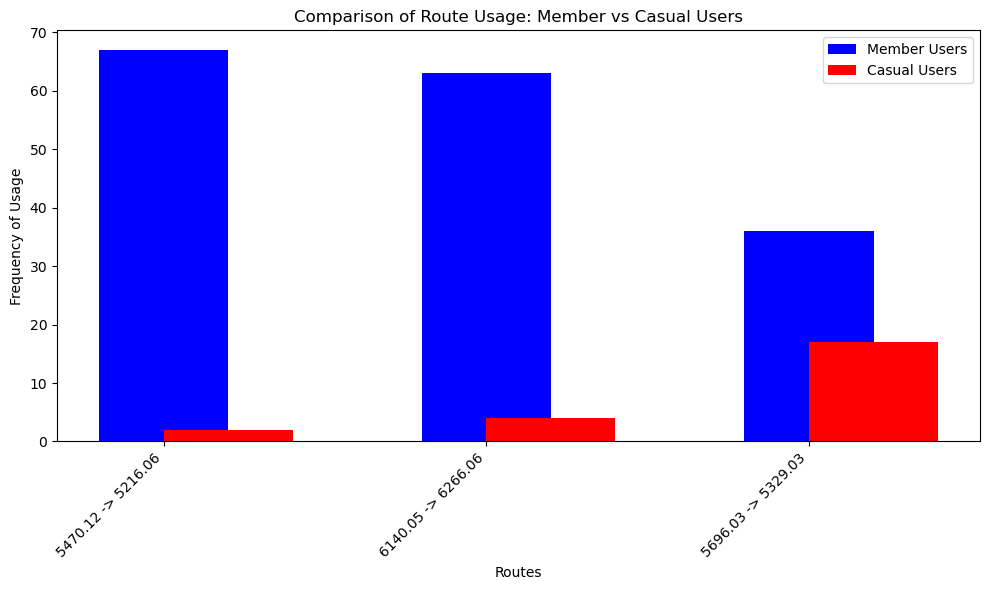

In [31]:
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制柱状图
x = route_comparison_df['route']
member_counts = route_comparison_df['member_count']
casual_counts = route_comparison_df['casual_count']

plt.bar(x, member_counts, width=0.4, label='Member Users', color='b', align='center')
plt.bar(x, casual_counts, width=0.4, label='Casual Users', color='r', align='edge')

# 添加图形标题和标签
plt.title('Comparison of Route Usage: Member vs Casual Users')
plt.xlabel('Routes')
plt.ylabel('Frequency of Usage')
plt.xticks(rotation=45, ha='right')
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()
